In [1]:
#CAUTION: Takes a long time to load.
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [21]:
#Add columns
unscaled_data <- read_csv("pulsar_data.csv", 
                        col_names = c("mean_integrated_profile", 
                                      "stand_dev_integrated_profile", 
                                      "exc_kurtosis_integrated_profile", 
                                      "skew_integrated_profile",
                                      "mean_dmsnr", 
                                      "stand_dev_dmsnr", 
                                      "exc_kurtosis_dmsnr", 
                                      "skew_dmsnr", "class")) 

unscaled_data <- unscaled_data |>
    mutate(class = as_factor(class))
#unscaled_data 

#Class proportions in pulsar dataset (Imbalanced)
num_obs <- nrow(unscaled_data)
pulsar_proportions <- unscaled_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(unscaled_data))
pulsar_proportions

#Scale data and Upsample to balance data
pulsar_recipe <- recipe(class ~ skew_integrated_profile + skew_dmsnr, data = unscaled_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()

standardized_pulsar <- bake(pulsar_recipe, unscaled_data)
standardized_pulsar

#check proportions of upsampled data
new_pulsar_proportions <- standardized_pulsar |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(standardized_pulsar))
new_pulsar_proportions

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,n,percent
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


skew_integrated_profile,skew_dmsnr,class
<dbl>,<dbl>,<fct>
-0.4004478,-0.2874301,0
-0.3705251,0.2115755,0
-0.1165896,-0.3913625,0
-0.3901672,-0.4812869,0
-0.1048632,1.3867553,0
⋮,⋮,⋮
-0.1693495,-1.0001874,1
5.8648507,-0.9413518,1
0.5249475,-0.9954120,1


class,n,percent
<fct>,<int>,<dbl>
0,16259,50
1,16259,50


skew_integrated_profile,skew_dmsnr,class
<dbl>,<dbl>,<fct>
-0.4004478,-0.2874301,0
-0.3705251,0.2115755,0
-0.1165896,-0.3913625,0
-0.3901672,-0.4812869,0
-0.1048632,1.3867553,0
⋮,⋮,⋮
-0.1693495,-1.0001874,1
5.8648507,-0.9413518,1
0.5249475,-0.9954120,1


In [22]:
set.seed(1)
pulsar_split <- initial_split(standardized_pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

pulsar_recipe <- recipe(class ~ skew_integrated_profile + skew_dmsnr, data = standardized_pulsar)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    fit(data = pulsar_train)
pulsar_fit

pulsar_test_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_test_predictions

pulsar_prediction_accuracy <- pulsar_test_predictions |>
    metrics(truth = class, estimate = .pred_class) |>
    filter(.metric == "accuracy")
pulsar_prediction_accuracy

confusion <- pulsar_test_predictions |>
    conf_mat(truth = class, estimate = .pred_class)
confusion

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.0271445
Best kernel: rectangular
Best k: 3

.pred_class,skew_integrated_profile,skew_dmsnr,class
<fct>,<dbl>,<dbl>,<fct>
0,-0.4004478,-0.2874301,0
0,-0.3705251,0.2115755,0
0,-0.2409772,-0.6292692,0
0,-0.2683108,0.8513931,0
0,-0.3286328,1.1132819,0
⋮,⋮,⋮,⋮
1,0.3127610,-0.9926231,1
1,1.3631719,-0.9950951,1
1,-0.1693495,-1.0001874,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9687577


          Truth
Prediction    0    1
         0 3811    0
         1  254 4065

In [23]:
#10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

pulsar_resample_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = pulsar_vfold)

pulsar_metrics <- collect_metrics(pulsar_resample_fit)
pulsar_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9710508,10,0.001107097,Preprocessor1_Model1
roc_auc,binary,0.9841526,10,0.001011940,Preprocessor1_Model1


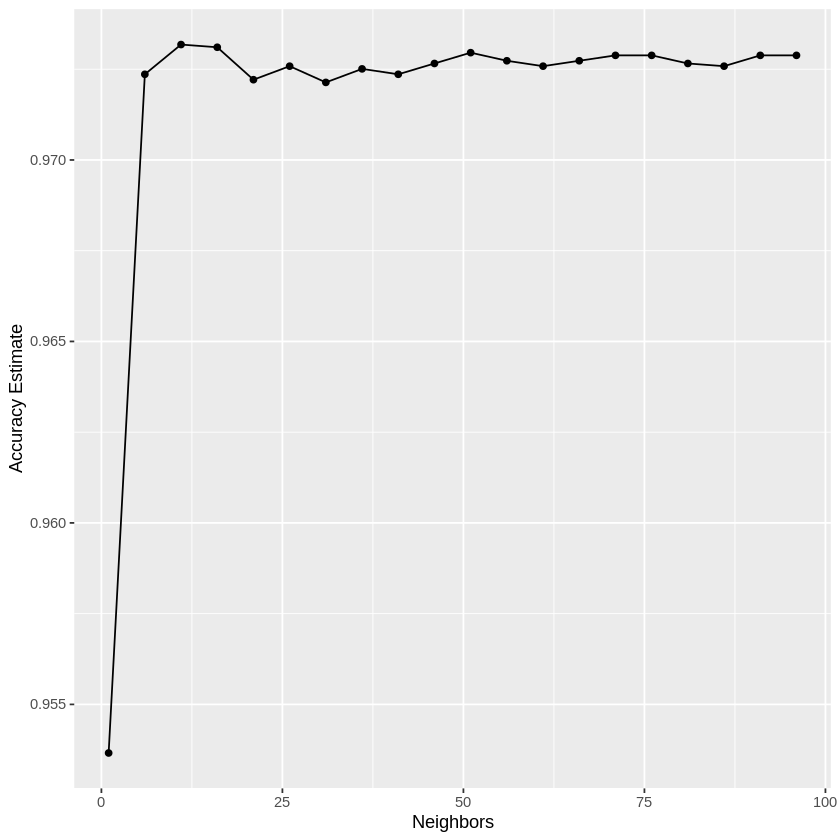

In [5]:
#CAUTION: Takes a long time to load.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
#knn_tune

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_tune) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics()
#knn_results

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")  
accuracy_versus_k


In [6]:
#we can have a separate cell for each combination of predictors that we try
#pick one K value to use for all the combinations, to avoid having to find the best K each time (which could vary)
#we could call the predictor combinations combo1, combo2, etc.
#compare their accuracies, choose the most accurate set of predictors
#Read Chapter 6.8 on selecting good predictors.